In [668]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import eli5
import scipy.stats as st
from eli5.formatters.as_dataframe import explain_weights_df
from eli5.sklearn import PermutationImportance
from xgboost import XGBRegressor
from category_encoders import OrdinalEncoder,OneHotEncoder
from imblearn.over_sampling import ADASYN
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LinearRegression, BayesianRidge
from sklearn.linear_model import HuberRegressor, RANSACRegressor, TheilSenRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer

from sksurv.ensemble import GradientBoostingSurvivalAnalysis, ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.datasets import get_x_y
from sksurv.metrics import concordance_index_ipcw, as_concordance_index_ipcw_scorer, brier_score

import warnings
warnings.filterwarnings('ignore')

In [669]:
df = pd.read_csv('data/RUL_regression.csv')
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,28056.0,NaN,NaN,NaN,50.557243,28.629237,1.0,26.0,51.0,75.0,100.0
Datetime,28056,361,2015-02-21,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cycle,28056.0,NaN,NaN,NaN,166.031865,94.886557,1.0,84.0,164.0,245.0,363.0
Voltage_mean,28056.0,NaN,NaN,NaN,170.76043,4.706852,157.745683,168.055649,170.192722,172.475352,218.265191
Rotate_mean,28056.0,NaN,NaN,NaN,446.78477,17.716433,271.246607,441.536424,449.192198,456.33845,493.381312
Pressure_mean,28056.0,NaN,NaN,NaN,100.806369,4.626168,90.973896,98.660468,100.103726,101.586085,152.3146
Vibration_mean,28056.0,NaN,NaN,NaN,40.377697,2.038066,36.163723,39.368793,40.069101,40.82825,61.113082
Model,28056,4,model3,9461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,28056.0,NaN,NaN,NaN,11.200064,5.904624,0.0,6.0,11.0,16.0,20.0
DI,28056.0,NaN,NaN,NaN,1.353352,0.687165,0.0,0.787464,1.312205,1.907928,2.701757


In [670]:
cols1 = [col for col in df.columns if '_max' in col]
cols2 = [col for col in df.columns if '_min' in col]
cols3 = [col for col in df.columns if '_mean' in col]
col_list = [cols1, cols2, cols3]

def change_db(df, col_list):
  df_copy = df.copy()
  for cols in col_list:
    for col in cols:
      if 'Rotate' in col:
        df_copy[col] = np.log1p(-df_copy[col] + df_copy[col].max()) # neg skewed를 정규분포로 변환
      else:
        df_copy[col] = np.log1p(df_copy[col]) # pos skewed를 정규분포로 변환
  return df_copy

df = change_db(df, col_list)

In [671]:
df['RUL'] += 1.0

In [672]:
# model1_df = df[df['Model'] == ('model' + str(1))].reset_index(drop=True)
# model2_df = df[df['Model'] == ('model' + str(2))].reset_index(drop=True)
# model3_df = df[df['Model'] == ('model' + str(3))].reset_index(drop=True)
# model4_df = df[df['Model'] == ('model' + str(4))].reset_index(drop=True)

In [673]:
# model1 = change_db(model1_df, col_list)
# model2 = change_db(model2_df, col_list)
# model3 = change_db(model3_df, col_list)
# model4 = change_db(model4_df, col_list)

In [674]:
target = ['Failed','RUL']

# Test set. 모델별 3개의 ID 추출
np.random.seed(42)
test_id_list = []
for i in range(1,5):
  ids = list(np.random.choice(df.loc[df['Model'] == 'model' + str(1), 'ID'].unique(), 3))
  test_id_list += ids

train, test = df.query('ID not in @test_id_list'), df.query('ID in @test_id_list').copy()
test.reset_index(drop=True, inplace=True)

drop_col = ['ID','Datetime']
train = train.drop(columns=drop_col)
test = test.drop(columns=drop_col)

x_train, y_train = get_x_y(train, target, pos_label=True)
x_test, y_test = get_x_y(test, target, pos_label=True)
  
pipe = Pipeline([('encoder', OrdinalEncoder()),
                 ('scaler', StandardScaler()),
                 ('poly', PolynomialFeatures(degree=2))
                 ]).set_output(transform='pandas')

x_train_scaled = pipe.fit_transform(x_train)
x_test_scaled = pipe.transform(x_test)
y_train_real = train['RUL'] # cross_val 평가용 변수
y_real = test['RUL'] - 1 # 예측값과 비교를 위한 RUL 실제값

In [675]:
params = {'n_estimators': hp.quniform('n_estimators', 30, 201, 10),
          'subsample': hp.uniform('subsample', 0.5, 1.0),
          'learning_rate': hp.uniform('learning_rate', 0.05, 0.2)}

# params = {'max_depth': hp.quniform('max_depth', 1, 10, 1),
#           'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 31, 5),
#           'min_samples_split': hp.quniform('min_samples_split', 2, 11, 2),
#           'n_estimators': hp.quniform('n_estimators', 30, 201, 10),
#           'max_features': hp.uniform('max_features', 0.5, 1.0),
#           'learning_rate': hp.uniform('learning_rate', 0.05, 0.2)}

In [676]:
## bayesian_search
def survival_model(params):
  # params['max_depth'] = int(params['max_depth'])
  params['n_estimators'] = int(params['n_estimators'])
  
  model = ComponentwiseGradientBoostingSurvivalAnalysis(loss='ipcwls', random_state=42)
  model.set_params(**params)
  return model

def bayesian_search(params):
  model = survival_model(params)
  cv_pred = cross_val_predict(reg_model, x_train_scaled, y_train, cv=5)
  avg_score = mean_absolute_error(y_train_real, cv_pred)
  
  return {'loss': avg_score, 'status': STATUS_OK}

trials = Trials()
best_params = fmin(fn=bayesian_search, space=params, algo=tpe.suggest, max_evals=50,
                   trials=trials, rstate=np.random.default_rng(42))

best = trials.best_trial['misc']['vals']
print('best params :', best)
print('best score :', trials.best_trial['result']['loss'])

100%|██████████| 50/50 [13:39<00:00, 16.39s/trial, best loss: 25.43696380450882]
best params : {'learning_rate': [0.18258899382089233], 'n_estimators': [140.0], 'subsample': [0.9068277038201439]}
best score : 25.43696380450882


In [677]:
reg_model = ComponentwiseGradientBoostingSurvivalAnalysis(loss='ipcwls', random_state=42,
                                                          learning_rate=best['learning_rate'][0],
                                                          n_estimators=int(best['n_estimators'][0]),
                                                          subsample=best['subsample'][0])

# reg_model = GradientBoostingSurvivalAnalysis(loss='ipcwls', criterion='friedman_mse', random_state=42,
#                                            min_samples_leaf=best['min_samples_leaf'][0],
#                                            min_samples_split=best['min_samples_split'][0],
#                                            max_depth=int(best['max_depth'][0]),
#                                            n_estimators=int(best['n_estimators'][0]),
#                                            max_features=best['max_features'][0],
#                                            learning_rate=best['learning_rate'][0])

# 교차검증
# scores = cross_val_score(reg_model, x_train_scaled, y_train, cv=5)
# avg_score = scores.mean()
cv_pred = cross_val_predict(reg_model, x_train_scaled, y_train, cv=5)
avg_score = mean_absolute_error(y_train_real, cv_pred)
  
reg_model.fit(x_train_scaled, y_train)
y_train_pred = reg_model.predict(x_train_scaled)
y_pred = reg_model.predict(x_test_scaled) - 1 # RUL 예측값

train_score = mean_absolute_error(y_train_real, y_train_pred)
mse = mean_squared_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
mae = mean_absolute_error(y_real, y_pred)
r2 = r2_score(y_real, y_pred)
  
eval_scores = pd.Series([train_score, avg_score, mse, rmse, mae, r2], index=['Train', 'CV average', 'MSE', 'RMSE', 'MAE', 'R2'])
print(eval_scores)

Train          25.230243
CV average     25.436964
MSE           189.326754
RMSE           13.759606
MAE            10.900833
R2              0.354819
dtype: float64


In [678]:
def pred_plot(y_real, y_pred, threshold):
  plt.figure(figsize=(12,3))
  plt.plot(y_pred, color='r', alpha=.7, label='Predict')
  plt.plot(y_real, color='b', label='Real')
  plt.axhline(threshold, color='orange', label='MAE')
  plt.title(f'Final Model Predict')
  plt.xlabel('List ID Cycles')
  plt.ylabel('RUL')
  plt.legend()
  plt.show()

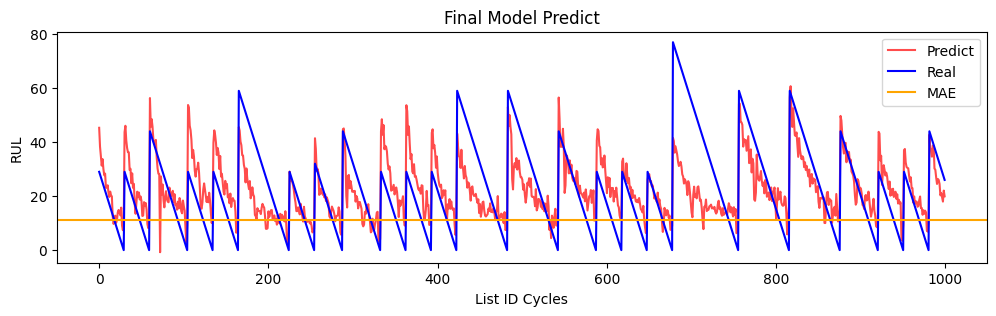

In [679]:
pred_plot(y_real[:1000], y_pred[:1000], 11)

In [680]:
### 이제 알게된 make score
def custom_scoring(y_test, y_pred):
  name_event, name_time = y_test.dtype.names
  y_real = y_test[name_time]
  
  return mean_absolute_error(y_real, y_pred)

custom_mae = make_scorer(custom_scoring, greater_is_better=False)

In [681]:
permuter = PermutationImportance(reg_model, scoring=custom_mae,
                                 n_iter=5, random_state=42)
permuter.fit(x_test_scaled, y_test)

pi = explain_weights_df(permuter, feature_names=x_test_scaled.columns.to_list())
pi_20 = pi.head(20)
pi_20.style.background_gradient(cmap='summer')

,feature,weight,std
0,DI,4.300063,0.114835
1,Age,0.244435,0.016884
2,Cycle^2,0.175893,0.087478
3,Cycle,0.141080,0.012135
4,Cycle DI,0.065151,0.016323
5,Model Pressure_max,0.060549,0.056715
6,Age Vibration_max,0.046475,0.012675
7,Rotate_min,0.034888,0.039522
8,Vibration_max,0.034054,0.012112
9,Voltage_mean DI,0.017195,0.013684


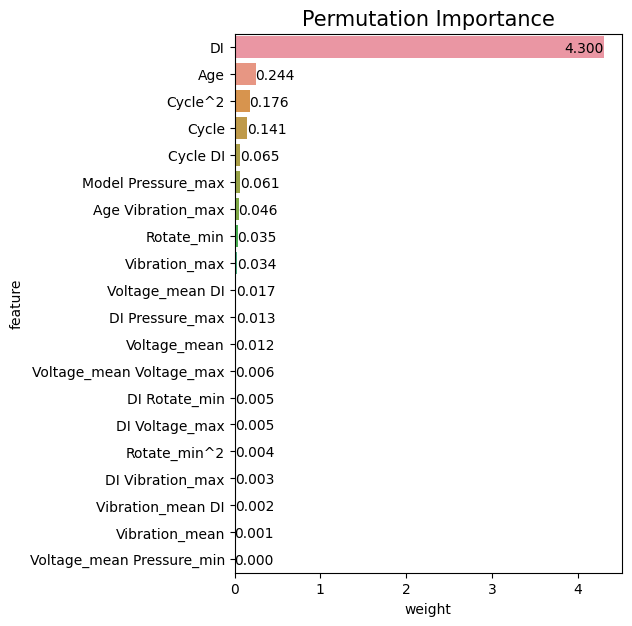

In [682]:
plt.figure(figsize=(5,7))
ax = sns.barplot(pi_20, x='weight', y='feature')
ax.set_title('Permutation Importance', fontsize=15)
for i, p in enumerate(pi_20['weight'].to_list()):
  if p > 3:
    ax.text(p, i + 0.2, f'{p:.3f}', ha='right')
  else:
    ax.text(p, i + 0.2, f'{p:.3f}', ha='left')

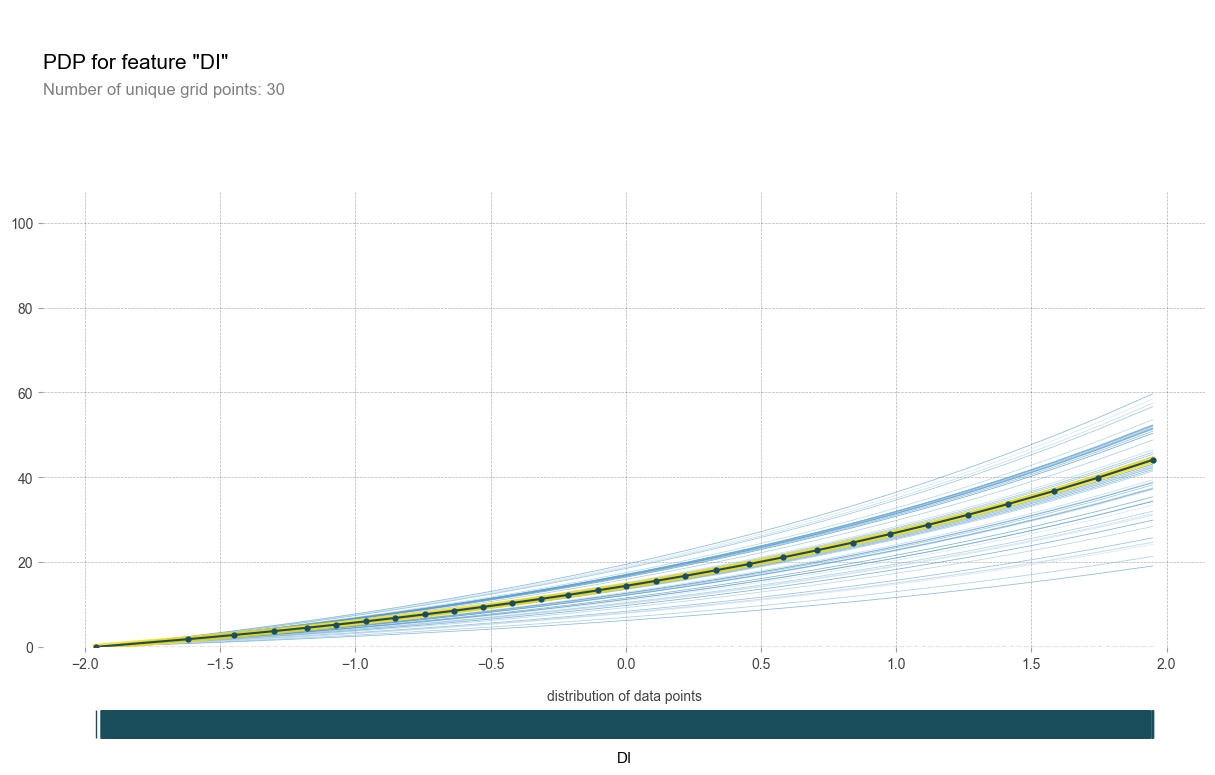

In [695]:
col = 'DI'

isol = pdp_isolate(reg_model, x_train_scaled, model_features=x_train_scaled.columns,
                   feature=col, num_grid_points=30)

fig, ax = pdp_plot(isol, col, plot_lines=True, frac_to_plot=50, plot_pts_dist=True)

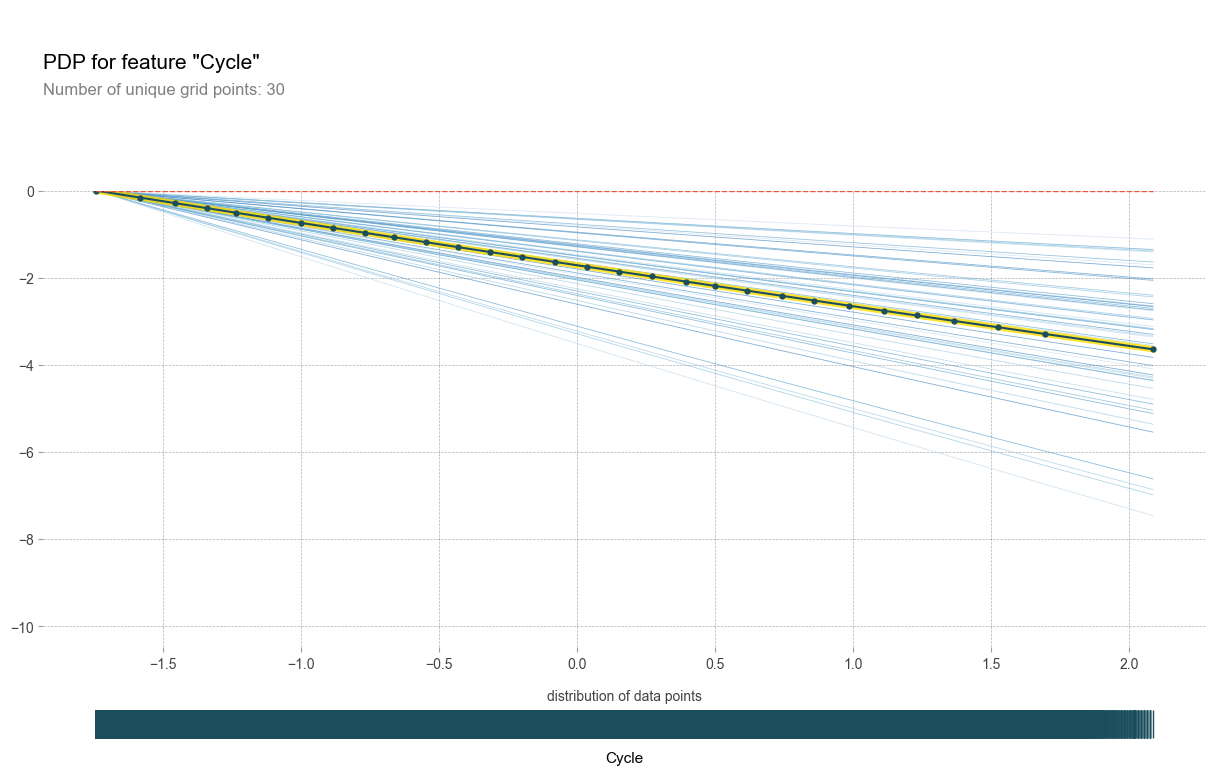

In [692]:
col = 'Cycle'

isol = pdp_isolate(reg_model, x_train_scaled, model_features=x_train_scaled.columns,
                   feature=col, num_grid_points=30)

fig, ax = pdp_plot(isol, col, plot_lines=True, frac_to_plot=50, plot_pts_dist=True)

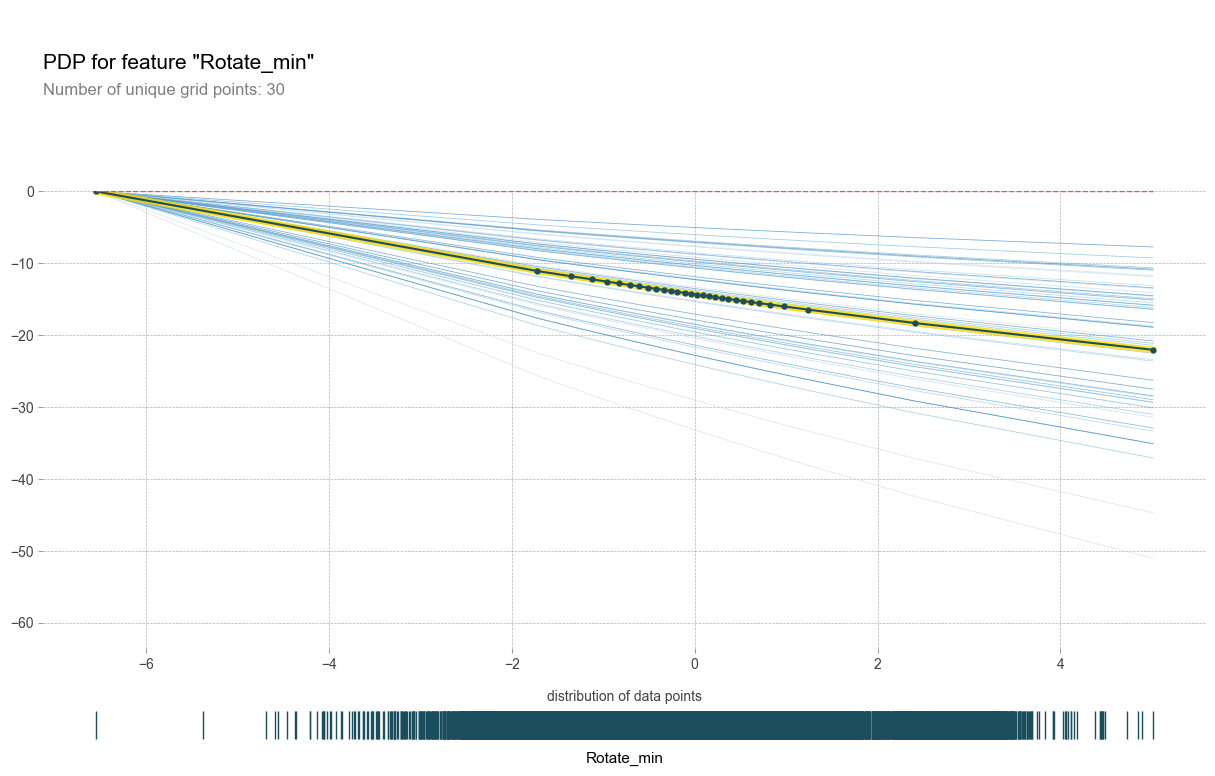

In [687]:
col = 'Rotate_min'

isol = pdp_isolate(reg_model, x_train_scaled, model_features=x_train_scaled.columns,
                   feature=col, num_grid_points=30)

pdp_plot(isol, col, plot_lines=True, frac_to_plot=50, plot_pts_dist=True);

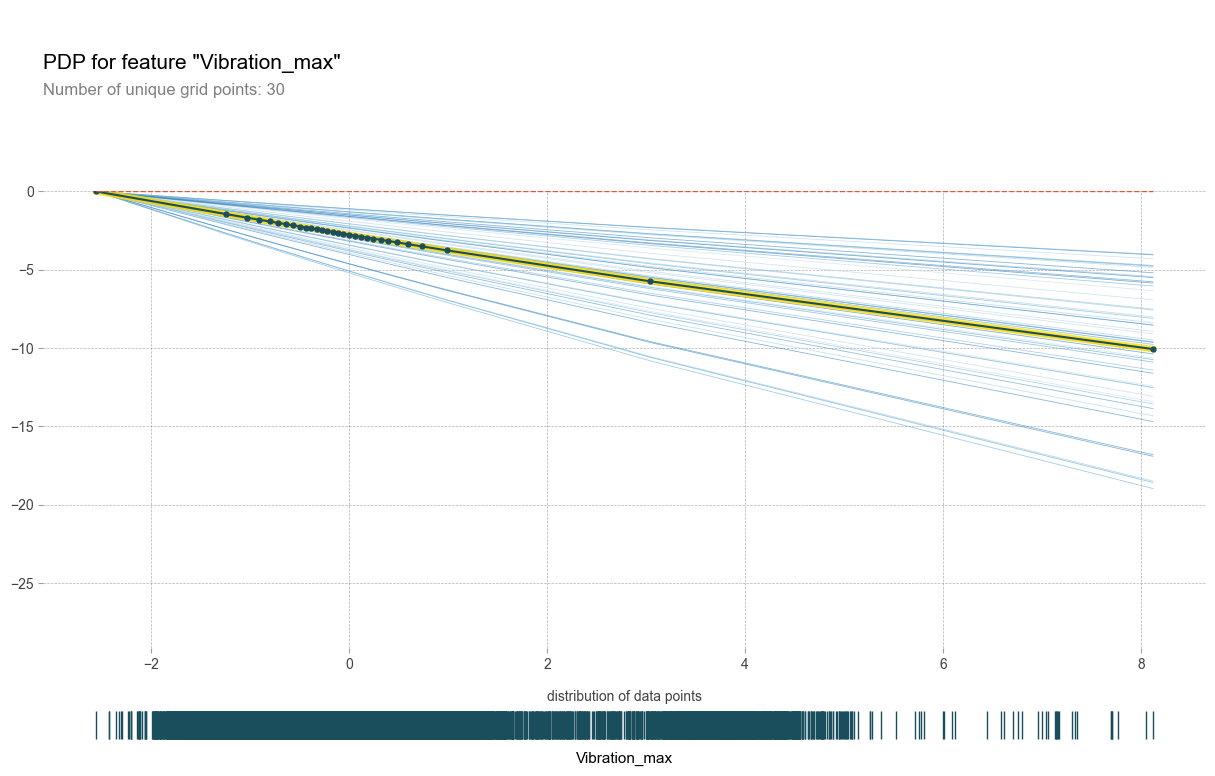

In [688]:
col = 'Vibration_max'

isol = pdp_isolate(reg_model, x_train_scaled, model_features=x_train_scaled.columns,
                   feature=col, num_grid_points=30)

pdp_plot(isol, col, plot_lines=True, frac_to_plot=50, plot_pts_dist=True);

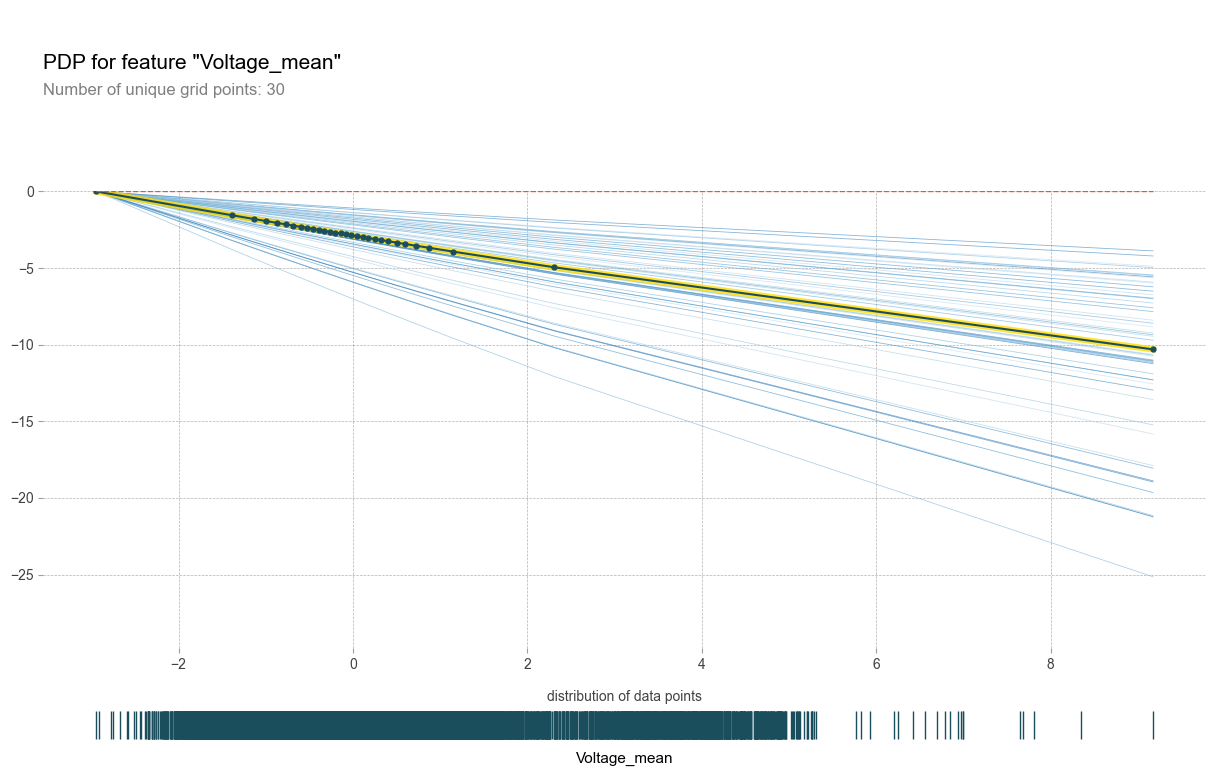

In [700]:
col = 'Voltage_mean'

isol = pdp_isolate(reg_model, x_train_scaled, model_features=x_train_scaled.columns,
                   feature=col, num_grid_points=30)

pdp_plot(isol, col, plot_lines=True, frac_to_plot=50, plot_pts_dist=True);